## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [71]:
%matplotlib inline
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Camera calibration data

In [72]:
nx = 9
ny = 6

def get_calibration_data(glob_arg='../camera_cal/calibration*.jpg', show=False):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6 * 9, 3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d points in real world space
    imgpoints = []  # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(glob_arg)

    img_shape = None

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        img_shape = img.shape[0:2]
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret:
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvec, lvec = cv2.calibrateCamera(objpoints, imgpoints, img_shape, None, None)
    return mtx, dist

## 1) Chessboard image calibration and Draw chessboard corners

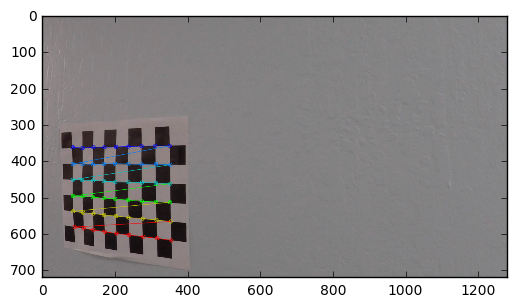

In [73]:
mtx, dist = get_calibration_data(show=True)

In [74]:
# Calculate the lane line curvature
def get_curvature(poly, image):
    yscale = 30 / 720
    xscale = 3.7 / 700
    ploty = np.linspace(0, image.shape[0] - 1, image.shape[0])
    fitx = poly[0] * ploty ** 2 + poly[1] * ploty + poly[2]
    fit_cr = np.polyfit(ploty * yscale, fitx * xscale, 2)
    curverad = ((1 + (2 * fit_cr[0] * np.max(ploty) * yscale + fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * fit_cr[0])
    return curverad

In [75]:
# Find the offset of the car and the base of the lane lines
def find_offset(l_poly, r_poly, image):
    lane_width = 3.7  # metres
    h = image.shape[0]
    w = image.shape[1]
    l_px = l_poly[0] * h ** 2 + l_poly[1] * h + l_poly[2]
    r_px = r_poly[0] * h ** 2 + r_poly[1] * h + r_poly[2]
    scale = lane_width / np.abs(l_px - r_px)
    midpoint = np.mean([l_px, r_px])
    offset = (w / 2 - midpoint) * scale
    return offset

## 2) Main class for line detector

In [76]:
# Define a class to receive the characteristics of each line detection
class LineDetector():
    def __init__(self, calibration_mtx, calibration_dist, margin=100, n_windows=9, minpix=50,
                 s_thresh=(0.5, 0.7), l_thresh=(0.7, 1.0), sx_thresh=(40, 100)):

        # restart sanity check
        self.current_frame_sc = 0
        self.frame_to_restart_sc = 45

        # Calibration parameters
        self.calibration_mtx = calibration_mtx
        self.calibration_dist = calibration_dist

        # update curvature rad
        self.update_rad_frame = 10
        self.current_frame = 0
        self.left_curvature_rad = None
        self.right_curvature_rad = None

        # center distance
        self.center_distance = None

        # Birds eye parameters
        bottom = 680
        middle = 470

        src = np.float32([
            [568, middle],
            [260, bottom],
            [717, middle],
            [1043, bottom]
        ])

        x_start = 200
        x_end = 1000

        dst = np.float32([
            [x_start, 0],
            [x_start, bottom],
            [x_end, 0],
            [x_end, bottom]
        ])

        self.M = cv2.getPerspectiveTransform(src, dst)
        self.Minv = cv2.getPerspectiveTransform(dst, src)

        # params for following video frames
        self.first_frame = True
        self.margin = margin

        # previous fits
        self.left_fit = None
        self.right_fit = None

        # sliding windows for first frame
        self.nwindows = n_windows

        # s and sx threshold
        self.s_thresh = s_thresh
        self.l_thresh = l_thresh
        self.sx_thresh = sx_thresh

        # minpix for resize window
        self.minpix = minpix

    def undistort_image(self, img):
        # Use cv2.calibrateCamera() and cv2.undistort()
        return cv2.undistort(img, self.calibration_mtx, self.calibration_dist, None, self.calibration_mtx)

    def pipeline(self, undistorted, show=False):
        undistorted = np.copy(undistorted)

        # Convert to HSV color space and separate the V channel
        hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS).astype(np.float)
        h_channel = hls[:, :, 0]
        l_channel = hls[:, :, 1]
        s_channel = hls[:, :, 2]
        # Sobel x
        sobel_x = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)  # Take the derivative in x
        abs_sobel_x = np.absolute(sobel_x)  # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255 * abs_sobel_x / np.max(abs_sobel_x))

        # Threshold x gradient
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= self.sx_thresh[0]) & (scaled_sobel <= self.sx_thresh[1])] = 1

        # using hue to detect yellow lines
        h_binary = np.zeros_like(h_channel)
        h_binary[(h_channel > 17) & (h_channel < 30)] = 1

        # Threshold s color channel
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= self.s_thresh[0]) & (s_channel <= self.s_thresh[1])] = 1

        # Threshold l color channel
        l_binary = np.zeros_like(l_channel)
        l_binary[(l_channel >= self.l_thresh[0]) & (l_channel <= self.l_thresh[1])] = 1
        # Stack each channel
        # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
        # be beneficial to replace this channel with something else.
        color_binary = np.dstack((np.zeros_like(sxbinary), h_binary, l_binary))

        combined_binary = np.zeros_like(sxbinary)
        combined_binary[(h_binary == 1) | (s_binary == 1) | (sxbinary == 1) | (l_binary == 1)] = 1

        if show:
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            f.tight_layout()

            ax1.imshow(undistorted)
            ax1.set_title('Original Image', fontsize=40)

            ax2.imshow(combined_binary, cmap='gray')
            ax2.set_title('output binary', fontsize=40)

            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
            plt.show()
        return color_binary, combined_binary

    def birds_eye_view(self, img):
        # Compute and apply perpective transform
        img_size = (img.shape[1], img.shape[0])
        warped = cv2.warpPerspective(img, self.M, img_size,
                                     flags=cv2.INTER_NEAREST)  # keep same size as input image
        return warped

    def get_fits(self, binary_warped, video_stats=False):

        # let's do a blind search
        if self.first_frame:

            # Assuming you have created a warped binary image called "binary_warped"
            # Take a histogram of the bottom half of the image
            histogram = np.sum(binary_warped[binary_warped.shape[0] / 2:, :], axis=0)
            # Create an output image to draw on and  visualize the result
            out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
            # Find the peak of the left and right halves of the histogram
            # These will be the starting point for the left and right lines
            midpoint = np.int(histogram.shape[0] / 2)
            left_x_base = np.argmax(histogram[:midpoint])
            right_x_base = np.argmax(histogram[midpoint:]) + midpoint

            # Choose the number of sliding windows
            # self.nwindows = 9
            # Set height of windows
            window_height = np.int(binary_warped.shape[0] / self.nwindows)
            # Identify the x and y positions of all nonzero pixels in the image
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Current positions to be updated for each window
            left_x_current = left_x_base
            right_x_current = right_x_base
            # Set the width of the windows +/- margin
            margin = self.margin
            # Set minimum number of pixels found to recenter window
            minpix = self.minpix
            # Create empty lists to receive left and right lane pixel indices
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(self.nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = binary_warped.shape[0] - (window + 1) * window_height
                win_y_high = binary_warped.shape[0] - window * window_height
                win_xleft_low = left_x_current - margin
                win_xleft_high = left_x_current + margin
                win_xright_low = right_x_current - margin
                win_xright_high = right_x_current + margin
                # Draw the windows on the visualization image
                cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
                cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
                # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (
                    nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (
                    nonzerox < win_xright_high)).nonzero()[0]
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    left_x_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:
                    right_x_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)

            # Extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds]
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]

            # Fit a second order polynomial to each
            self.left_fit = np.polyfit(lefty, leftx, 2)
            self.right_fit = np.polyfit(righty, rightx, 2)
            self.first_frame = False

            if not video_stats:
                return None

            # Generate x and y values for plotting
            plot_y = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
            left_fit_x = self.left_fit[0] * plot_y ** 2 + self.left_fit[1] * plot_y + self.left_fit[2]
            right_fitx = self.right_fit[0] * plot_y ** 2 + self.right_fit[1] * plot_y + self.right_fit[2]

            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

            fig = Figure()
            canvas = FigureCanvas(fig)
            ax = fig.gca()
            ax.imshow(out_img)
            ax.plot(left_fit_x, plot_y, color='yellow')
            ax.plot(right_fitx, plot_y, color='yellow')
            # fig.xlim(0, 1280)
            # fig.ylim(720, 0)
            width, height = fig.get_size_inches() * fig.get_dpi()
            canvas.draw()  # draw the canvas, cache the renderer

            return np.fromstring(canvas.tostring_rgb(), dtype='uint8').reshape(height, width, 3)
        # just search on the last frames
        else:
            # Assume you now have a new warped binary image
            # from the next frame of video (also called "binary_warped")
            # It's now much easier to find line pixels!
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            left_lane_inds = (
                (nonzerox > (
                    self.left_fit[0] * (nonzeroy ** 2) + self.left_fit[1] * nonzeroy + self.left_fit[
                        2] - self.margin)) & (
                    nonzerox < (
                        self.left_fit[0] * (nonzeroy ** 2) + self.left_fit[1] * nonzeroy + self.left_fit[
                            2] + self.margin)))
            right_lane_inds = (
                (nonzerox > (self.right_fit[0] * (nonzeroy ** 2) + self.right_fit[1] * nonzeroy + self.right_fit[
                    2] - self.margin)) & (
                    nonzerox < (self.right_fit[0] * (nonzeroy ** 2) + self.right_fit[1] * nonzeroy + self.right_fit[
                        2] + self.margin)))

            # Again, extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds]
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]
            # Fit a second order polynomial to each

            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)

            left_curve_rad = get_curvature(left_fit, binary_warped)
            right_curve_rad = get_curvature(right_fit, binary_warped)
            if abs(left_curve_rad - right_curve_rad) <= 1500:
                self.left_fit = left_fit
                self.right_fit = right_fit
                self.current_frame_sc = 0
            else:
                self.current_frame_sc += 1

            if not video_stats:
                return None

            # Create an image to draw on and an image to show the selection window
            fig = Figure()
            canvas = FigureCanvas(fig)
            ax = fig.gca()

            plot_y = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
            left_fit_x = self.left_fit[0] * plot_y ** 2 + self.left_fit[1] * plot_y + self.left_fit[2]
            right_fitx = self.right_fit[0] * plot_y ** 2 + self.right_fit[1] * plot_y + self.right_fit[2]

            out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
            window_img = np.zeros_like(out_img)
            # Color in left and right line pixels
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            left_line_window1 = np.array([np.transpose(np.vstack([left_fit_x - self.margin, plot_y]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fit_x + self.margin, plot_y])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - self.margin, plot_y]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + self.margin, plot_y])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))

            # Draw the lane onto the warped blank image
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
            result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
            ax.imshow(result)
            ax.plot(left_fit_x, plot_y, color='yellow')
            ax.plot(right_fitx, plot_y, color='yellow')
            ax.set_title("Prediction")

            width, height = fig.get_size_inches() * fig.get_dpi()
            canvas.draw()  # draw the canvas, cache the renderer

            return np.fromstring(canvas.tostring_rgb(), dtype='uint8').reshape(height, width, 3)

    def update_data(self, warped_image):

        # Calculate the new radii of curvature
        self.left_curvature_rad = get_curvature(self.left_fit, warped_image)
        self.right_curvature_rad = get_curvature(self.right_fit, warped_image)
        self.center_distance = find_offset(self.left_fit, self.right_fit, warped_image)

    def put_prediction(self, img, binary_warped):
        plot_y = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
        left_fit_x = self.left_fit[0] * plot_y ** 2 + self.left_fit[1] * plot_y + self.left_fit[2]
        right_fit_x = self.right_fit[0] * plot_y ** 2 + self.right_fit[1] * plot_y + self.right_fit[2]

        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fit_x, plot_y]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fit_x, plot_y])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.Minv, (img.shape[1], img.shape[0]))
        # Combine the result with the original image
        result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
        self.update_data(binary_warped)

        if self.current_frame == self.update_rad_frame or (
                        self.left_curvature_rad is None and self.right_curvature_rad is None):
            self.current_frame = 0
        else:
            self.current_frame += 1

        result = cv2.putText(result, "Left curve rad: %.2f (km)" % (self.left_curvature_rad * 0.001,),
                             (50, 50),
                             cv2.FONT_HERSHEY_SIMPLEX, 0.8,
                             (0, 255, 0), 2, cv2.LINE_AA)
        result = cv2.putText(result, "Right curve rad: %.2f (km)" % (self.right_curvature_rad * 0.001,),
                             (50, 80),
                             cv2.FONT_HERSHEY_SIMPLEX, 0.8,
                             (0, 255, 0), 2, cv2.LINE_AA)
        result = cv2.putText(result,
                             "Distance from center: %.2f (m)" % (self.center_distance,),
                             (50, 110),
                             cv2.FONT_HERSHEY_SIMPLEX, 0.8,
                             (0, 255, 0), 2, cv2.LINE_AA)
        # sanity check output
        result = cv2.putText(result,
                             "Sanity check: ",
                             (50, 140),
                             cv2.FONT_HERSHEY_SIMPLEX, 0.8,
                             (0, 255, 0), 2, cv2.LINE_AA)
        color = ((255, 0, 0), 'Fail!') if self.current_frame_sc else ((0, 255, 0), 'Ok!')
        result = cv2.putText(result,
                             color[1],
                             (225, 140),
                             cv2.FONT_HERSHEY_SIMPLEX, 0.8,
                             color[0], 2, cv2.LINE_AA)

        return result

    def image_pipeline(self, image, show=False, video_stats=False):
        undist = self.undistort_image(image)
        _, combined_binary = self.pipeline(undist, show=show)
        binary_warped = self.birds_eye_view(combined_binary)

        histogram = np.sum(binary_warped[binary_warped.shape[0] / 2:, :], axis=0)
        fig = Figure()
        canvas = FigureCanvas(fig)
        ax = fig.gca()

        ax.plot(histogram)
        ax.set_title("Lane lines histogram")
        ax.set_xlabel("Pixel position")
        ax.set_ylabel("Counts")
        width, height = fig.get_size_inches() * fig.get_dpi()
        canvas.draw()  # draw the canvas, cache the renderer
        histogram = np.fromstring(canvas.tostring_rgb(), dtype='uint8').reshape(height, width, 3)

        stats = self.get_fits(binary_warped, video_stats)

        # sanity check
        if self.current_frame_sc == self.frame_to_restart_sc:
            self.first_frame = True
            stats = self.get_fits(binary_warped, video_stats)

        output = self.put_prediction(undist, binary_warped)

        bn_w = np.zeros_like(binary_warped)
        bn_w[(binary_warped == 1)] = 255
        bn_w = cv2.cvtColor(bn_w, cv2.COLOR_GRAY2RGB)
        bn_w = cv2.resize(bn_w, (binary_warped.shape[1] // 2, binary_warped.shape[0] // 2))

        cb_w = np.zeros_like(combined_binary)
        cb_w[(combined_binary == 1)] = 255
        cb_w = cv2.cvtColor(cb_w, cv2.COLOR_GRAY2RGB)
        cb_w = cv2.resize(cb_w, (combined_binary.shape[1] // 2, binary_warped.shape[0] // 2))

        # binary images
        binaries = np.concatenate((cb_w, bn_w), axis=0)
        output = np.concatenate((output, binaries), axis=1)

        if video_stats:
            stats = np.concatenate((histogram, stats), axis=1)
            black_space = np.zeros((stats.shape[0], binary_warped.shape[1] // 2, 3))
            stats = np.concatenate((stats, black_space), axis=1)
            stats = cv2.resize(stats, (output.shape[1], stats.shape[0]))
            output = np.concatenate((output, stats), axis=0)

        return output

    def image_output(self, image_path):
        img = mpimg.imread(image_path)
        return self.image_pipeline(img, show=True)

    def produce_video(self, input_path, output_path, video_stats=False):
        self.first_frame = True
        self.current_frame_sc = 0
        self.current_frame = 0

        clip2 = VideoFileClip(input_path)
        clip = clip2.fl_image(lambda x: self.image_pipeline(x, video_stats=video_stats))
        clip.write_videofile(output_path, audio=False)
        
ld = LineDetector(mtx, dist, 
                  s_thresh=(0.6, 0.7), 
                  l_thresh=(0.8, 0.9), 
                  sx_thresh=(20, 100), 
                  n_windows=8, 
                  minpix=75)

## 3) Distorted and undistorted image

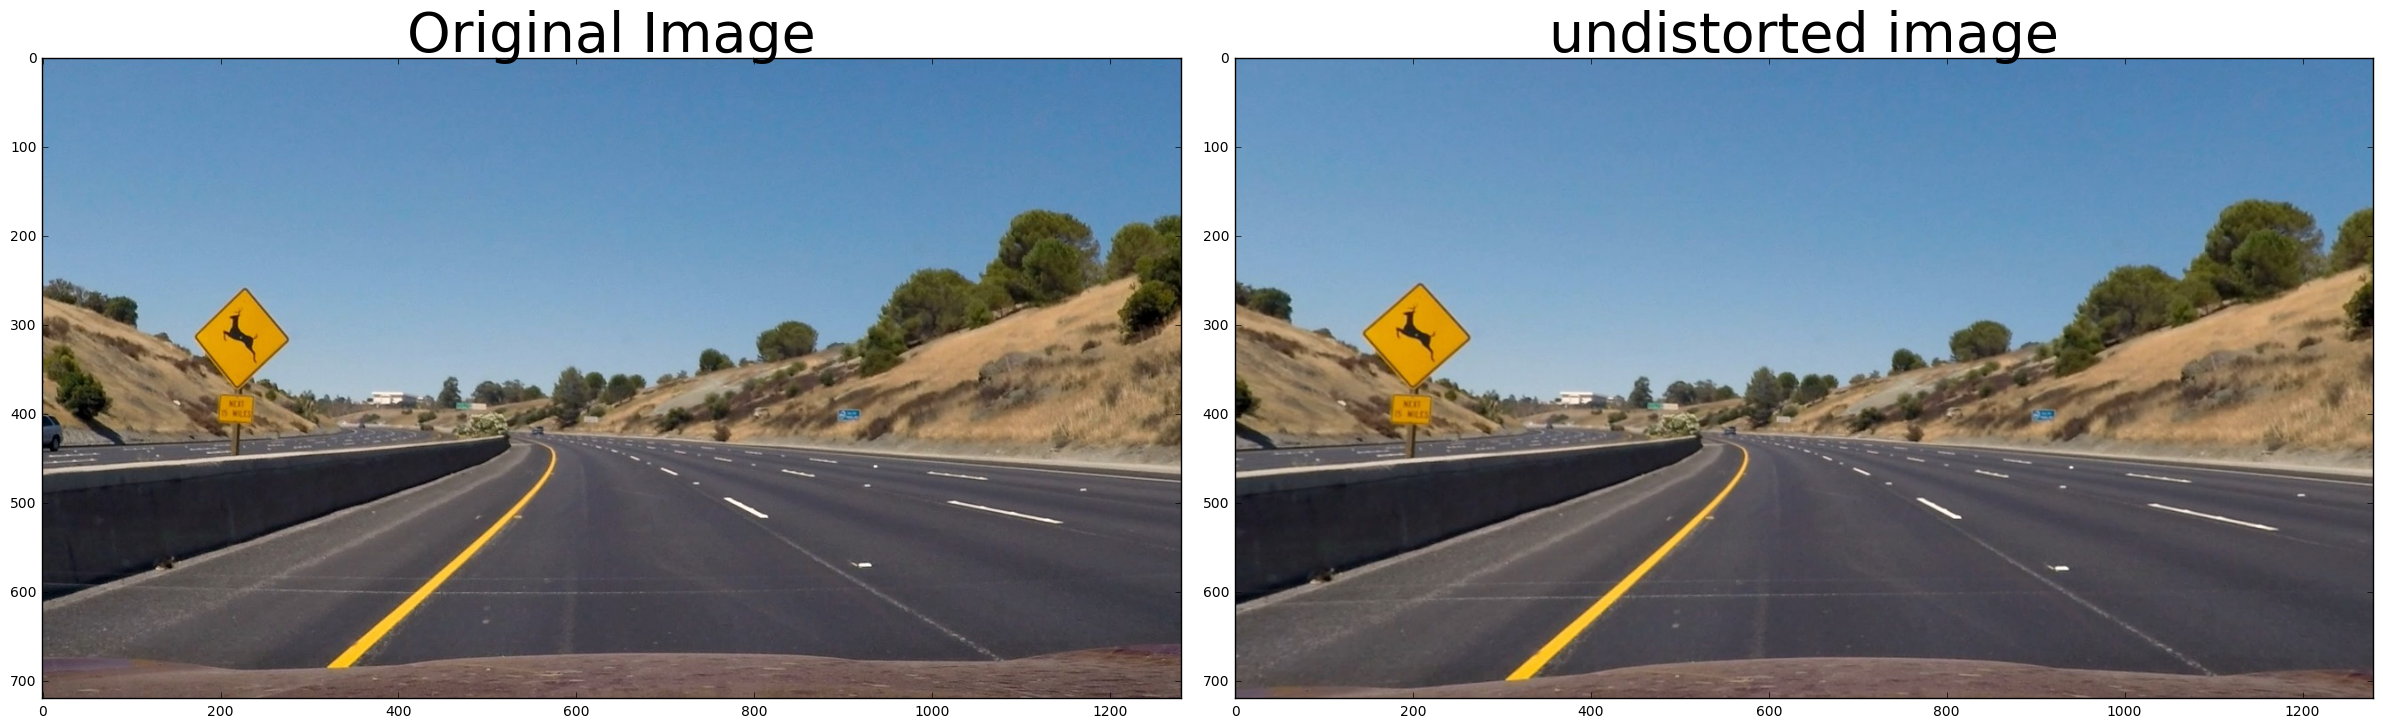

In [77]:
image_path = '../test_images/test2.jpg'
img = mpimg.imread(image_path)
undistorted = ld.undistort_image(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(undistorted)
ax2.set_title('undistorted image', fontsize=40)

## 4) Image pipeline

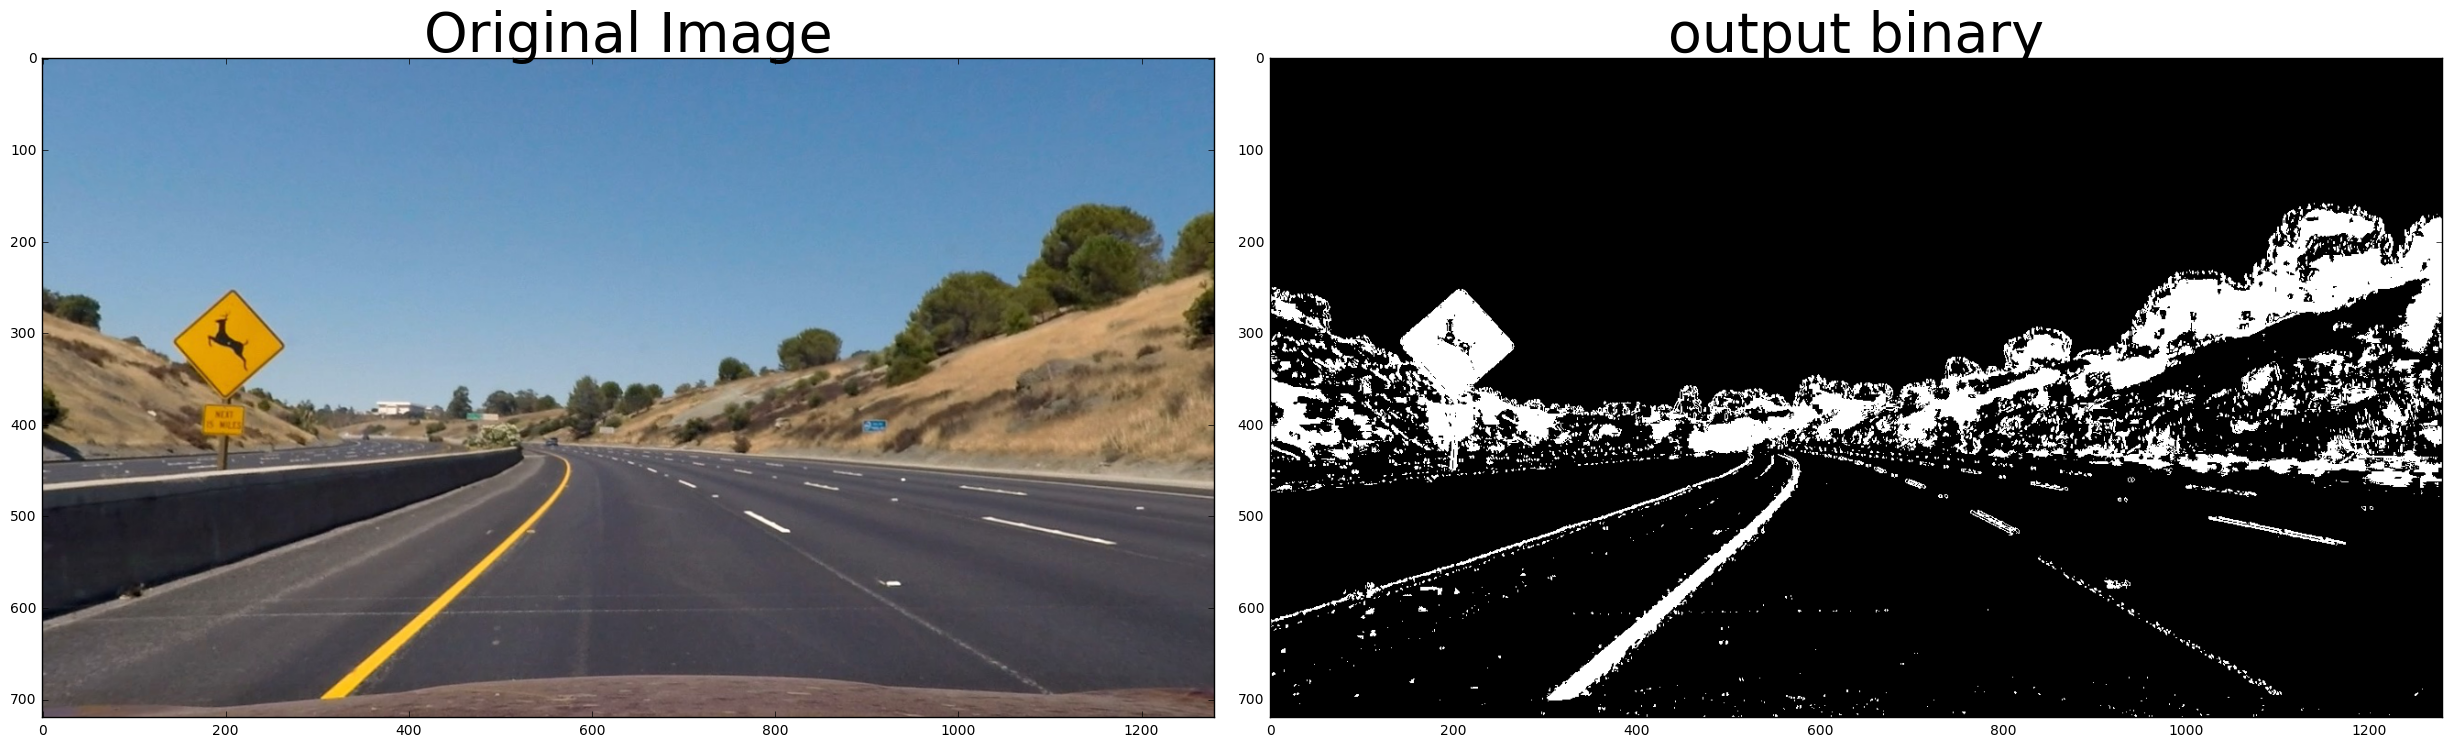

In [78]:
_, binary = ld.pipeline(undistorted, show=True)

## 5) Birds eye view

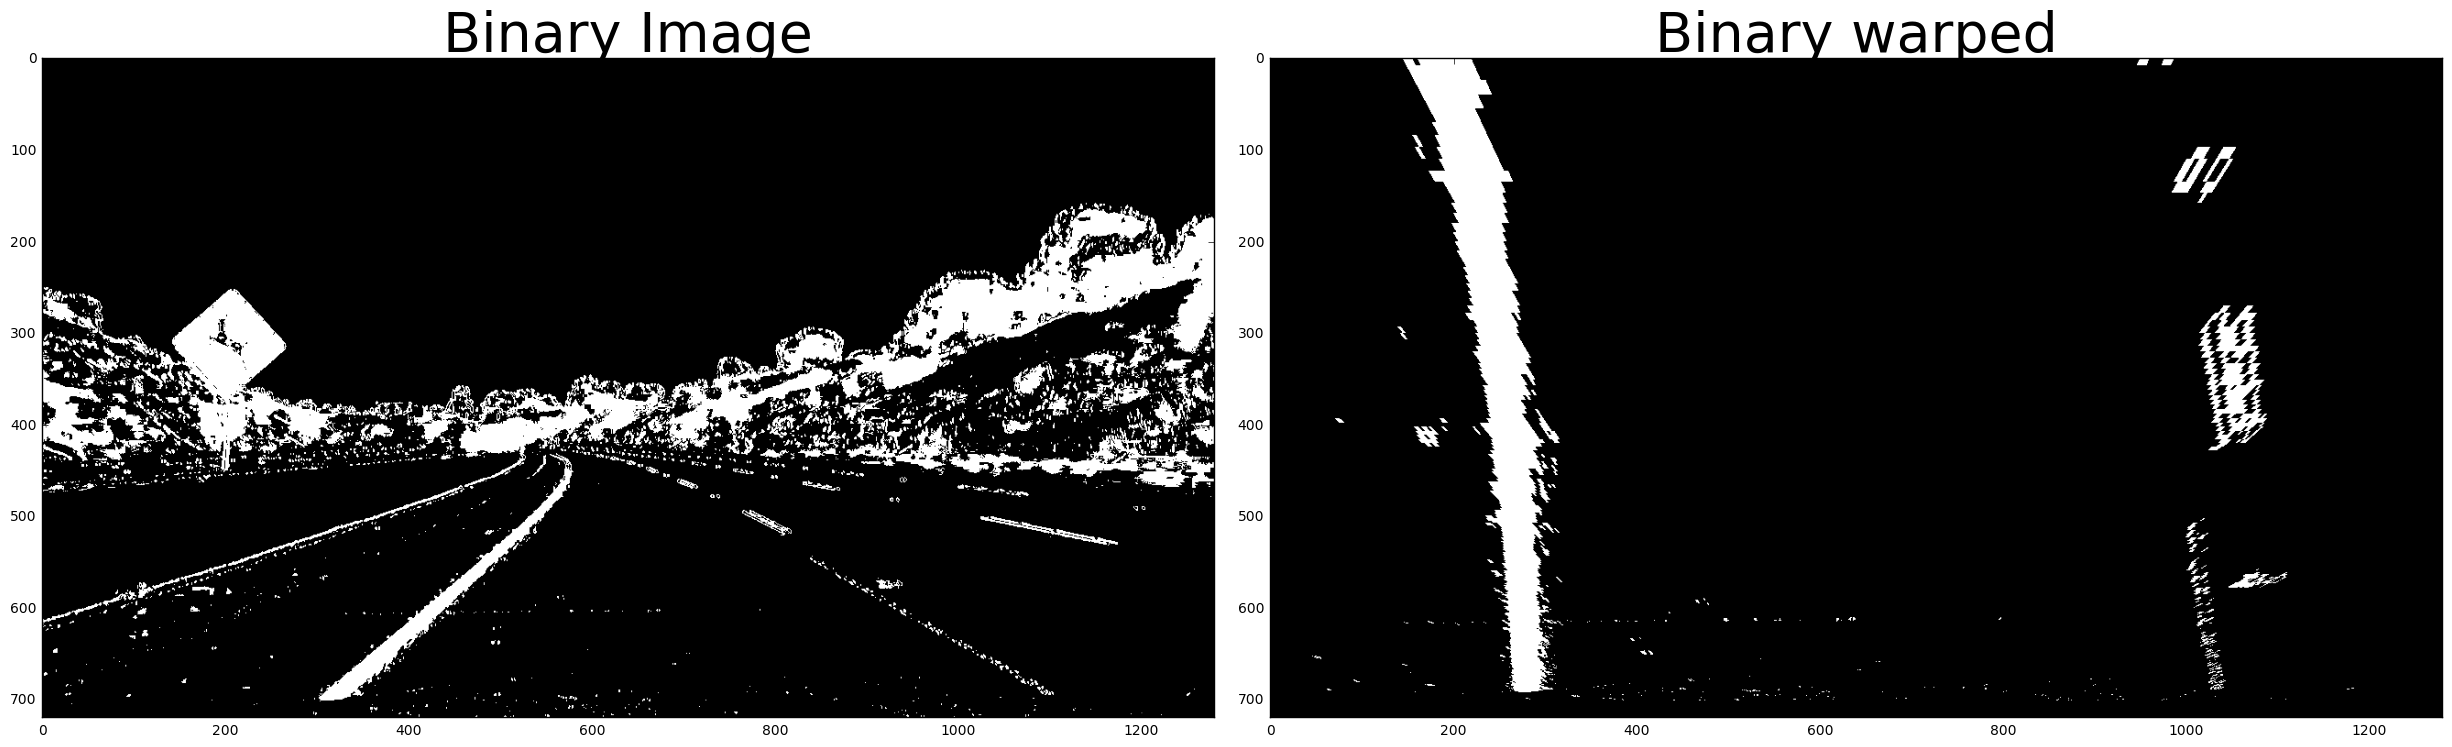

In [79]:
binary_warped = ld.birds_eye_view(binary)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(binary, cmap='gray')
ax1.set_title('Binary Image', fontsize=40)

ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Binary warped', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## 6) Prediction with sliding window

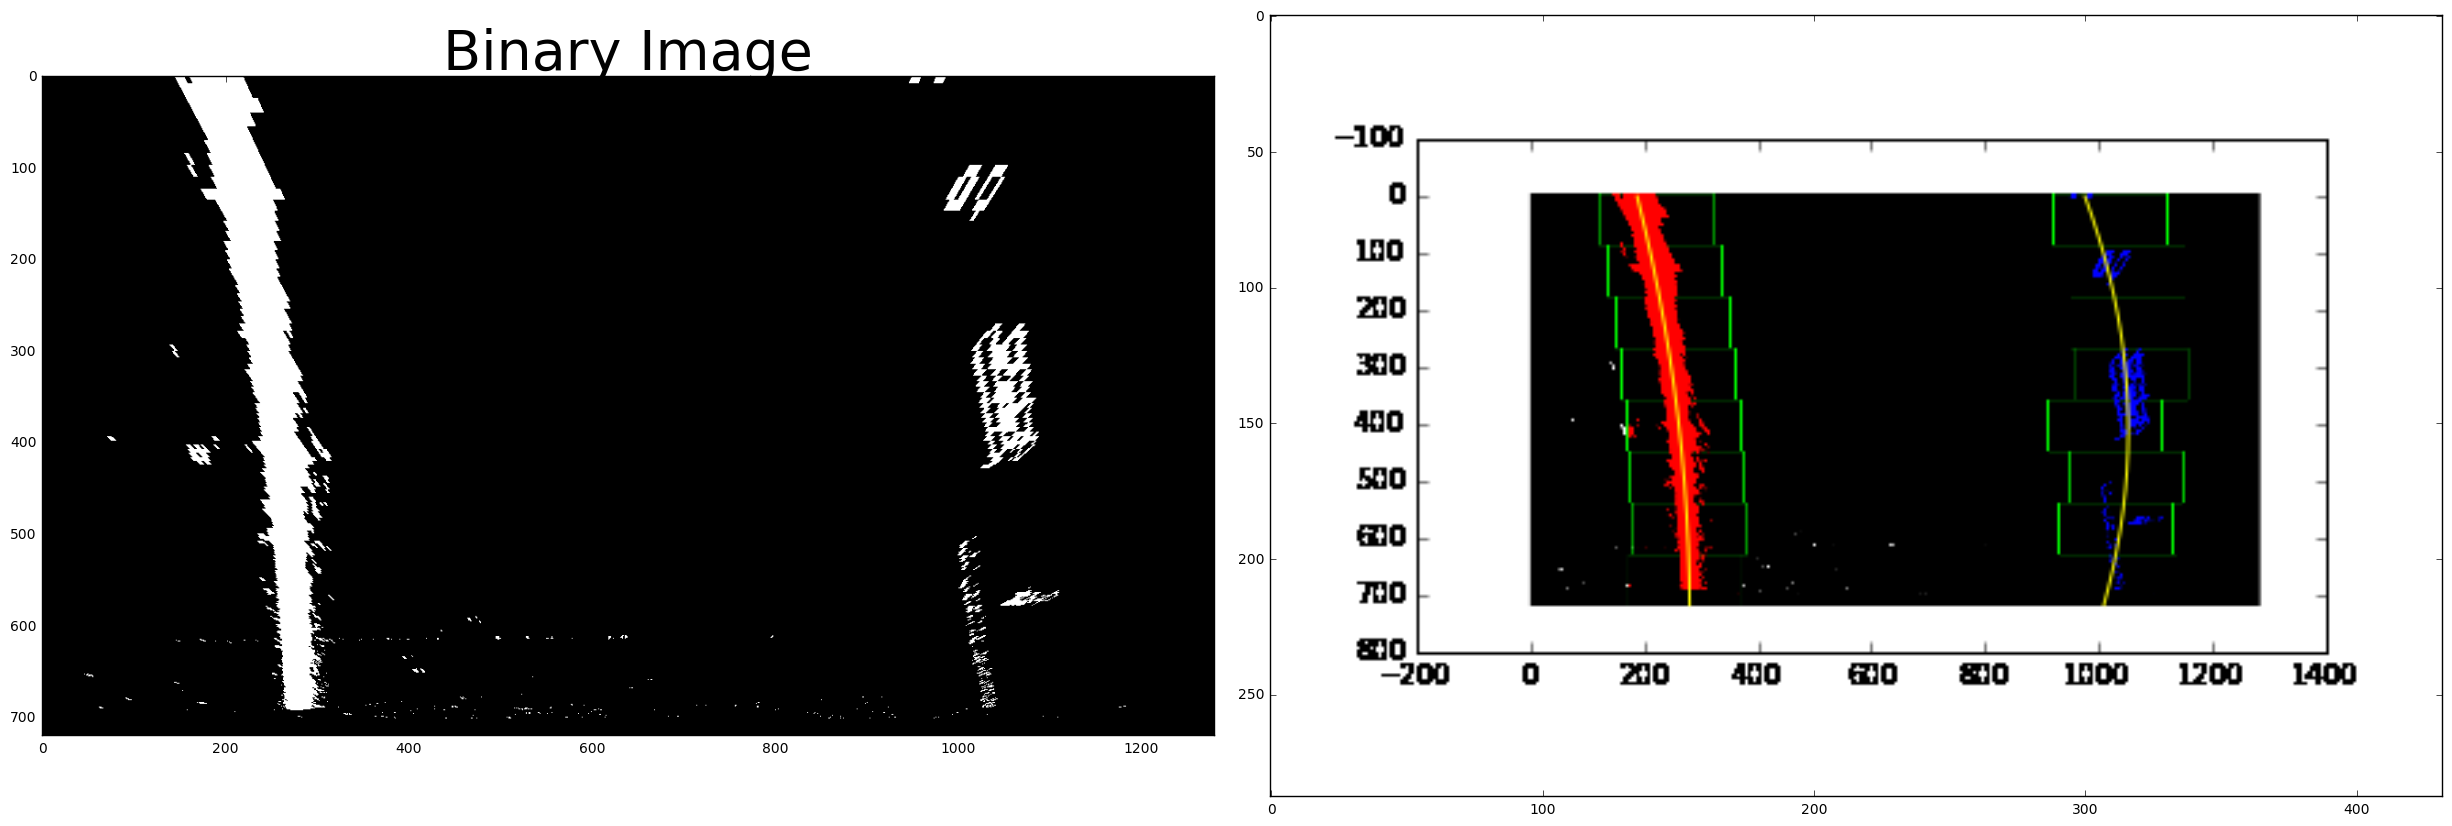

In [80]:
prediction = ld.get_fits(binary_warped, video_stats=True)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(binary_warped, cmap='gray')
ax1.set_title('Binary Image', fontsize=40)

ax2.imshow(prediction)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## 7) Put prediction over undistorted original image

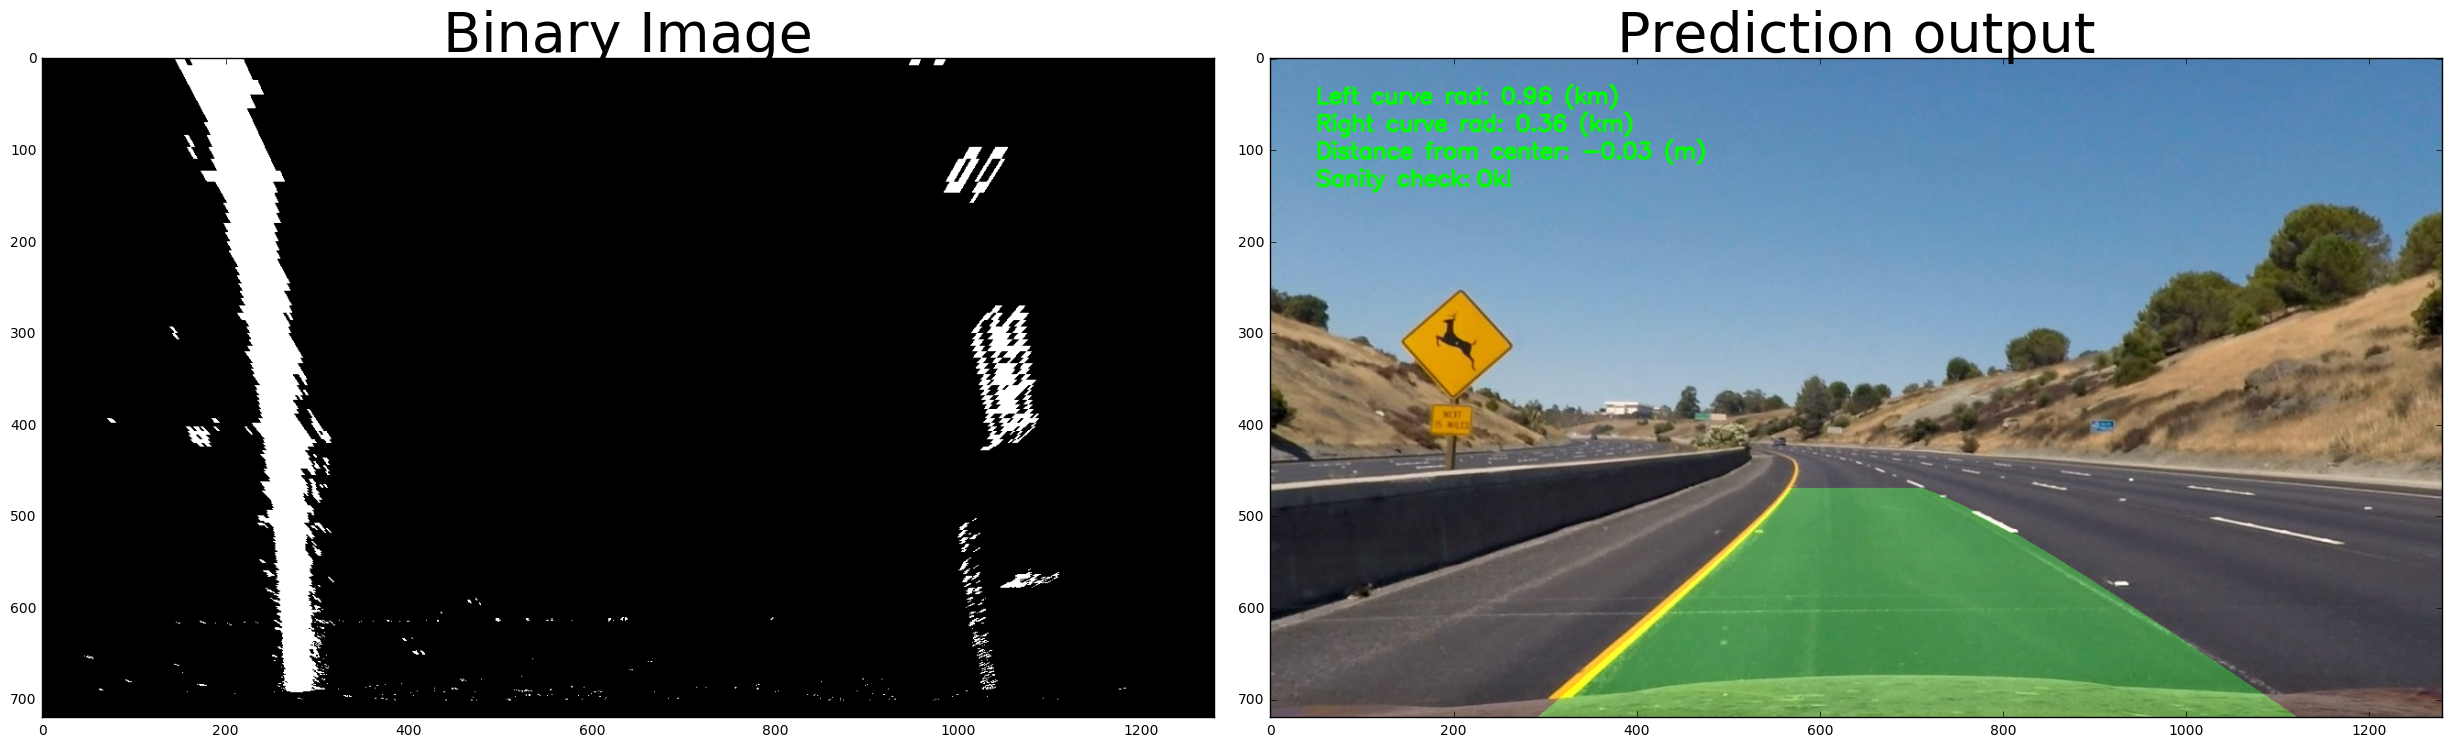

In [81]:
output = ld.put_prediction(undistorted, binary_warped)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(binary_warped, cmap='gray')
ax1.set_title('Binary Image', fontsize=40)

ax2.imshow(output)
ax2.set_title('Prediction output', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## 8) Apply full process over a video

**Note**: It's better to see the video on fullscreen

In [82]:
ld.produce_video('../project_video.mp4', '../output_images/output.mp4', video_stats=True)

[MoviePy] >>>> Building video ../output_images/output.mp4
[MoviePy] Writing video ../output_images/output.mp4



100%|█████████▉| 1260/1261 [07:34<00:00,  2.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_images/output.mp4 



In [84]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('../output_images/output.mp4'))